### Detecting permafrost in UKESM1 model output

The data used for this investigation was derived from a single UKESM1 run using its default low-resolution setup. The run followed the historical setup from 1850-2014 (Eyring et al., 2016), and branched at 2015 into different scenarios for the years 2015-2100 based on shared socioeconomic pathways (SSPs) and climate outcomes for 2100 driven by prescribed radiative forcings (O’Neill et al., 2016). For each scenario, UKESM1 output was analysed to identify the  the global area of permafrost using monthly surface air temperature (at 1.5 m) and soil temperature (at a depth of 2.0 m).

Permafrost areas were identified following the criteria of Slater and Lawrence (2013) as cells where the annual mean soil temperature at a depth of 2.0 m remained below 0°C for at least two consecutive years. Since this is likely to prove an underestimate of areas of discontinuous permafrost, the isotherm of mean annual surface temperature of 0°C and -4.3°C were also calculated, as these closely define areas where there is respectively >1% and >50% likelihood of finding permafrost (Chadburn et al., 2017). The surface area was calculated based on the cell areas, taking into account the percentage of the cell filled by land. Permanent ice cover was estimated based on mean annual snow cover > 95%.

In [1]:
#load packages
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import scipy

In [2]:
#calculate area of land for each cell
areacell = xr.open_dataset('../02-data/ukesm1-output/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
lndfrac = xr.open_dataset('../02-data/ukesm1-output/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')

acl = areacell['areacella'].values
lfr = lndfrac['sftlf'].values
lp = lfr/100
lndarea = np.multiply(acl,lp)

#set lat and lon
lat = areacell['lat']
lon = areacell['lon']

In [3]:
#load full datasets for each scenario

def load_full(info):
    '''function to load data for variable and scenario
    Arguments:
    =========
    info = array of str, ccontaining variable[0], letter[1], scenario[2]'''
    path1 = f'../02-data/ukesm1-output/{info[0]}_{info[1]}mon_UKESM1-0-LL_historical_r1i1p1f2_gn_*.nc'
    path2 = f'../02-data/ukesm1-output/{info[0]}_{info[1]}mon_UKESM1-0-LL_{info[2]}_r1i1p1f2_gn_*.nc'
    data1 = xr.open_mfdataset(paths=path1,combine='by_coords')
    data2 = xr.open_mfdataset(paths=path2,combine='by_coords')
    data3 = xr.concat([data1,data2],dim='time')
    return data3

#soil temperature
tsl126 = load_full(['tsl','L','ssp126'])
tsl245 = load_full(['tsl','L','ssp245'])
tsl370 = load_full(['tsl','L','ssp370'])
tsl585 = load_full(['tsl','L','ssp585'])

#air temperature
sat126 = load_full(['tas','A','ssp126'])
sat245 = load_full(['tas','A','ssp245'])
sat370 = load_full(['tas','A','ssp370'])
sat585 = load_full(['tas','A','ssp585'])

#snow coverage
snc126 = load_full(['snc','LI','ssp126'])
snc245 = load_full(['snc','LI','ssp245'])
snc370 = load_full(['snc','LI','ssp370'])
snc585 = load_full(['snc','LI','ssp585'])

In [4]:
#function to get masks for all data

def get_masks(soil,air,snow,startyear,endyear):
    '''function to derive masks for plotting maps for variable and scenario
    Arguments:
    =========
    soil = array of str, ccontaining variable[0], letter[1], senario[2]
    air
    snow
    startyear, endyear'''
    
    #get the two-year mean for soil
    d = soil.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    d1 = d['tsl']
    d2 = d1.sel(depth=2.0,method='nearest')
    d3 = d2-273.15
    d4 = d3.mean(dim='time')
    
    #mask for pf areas
    smask = d4
    smask = xr.where(smask>=0,np.nan,smask)
    smask = xr.where(smask<0,1,smask)
    
    #mask for ocean
    ocean = d4
    ocean = ocean.fillna(100)
    ocean = xr.where(ocean<100,np.nan,ocean)
    
    #get annual mean air
    a = air.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    a1 = a['tas']
    a2 = a1-273.15
    a3 = a2.mean(dim='time')
    
    #mask for airtemp contours
    a0mask = a3
    a0mask = xr.where(a0mask>=0,np.nan,a0mask)
    a0mask = xr.where(a0mask<0,1,a0mask)
    
    a43mask = a3
    a43mask = xr.where(a43mask>=-4.3,np.nan,a43mask)
    a43mask = xr.where(a43mask<-4.3,1,a43mask)
    
    #get 10-yr mean snow coverage
    sn = snow.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    sn1 = sn['snc']
    sn2 = sn1.mean(dim='time')
    
    #snow mask
    sncmask = sn2
    sncmask = xr.where(sncmask<95,np.nan,sncmask)
    sncmask = xr.where(sncmask>=95,1,sncmask)
    
    return smask,a0mask,a43mask,sncmask,ocean

maskhist = get_masks(tsl126,sat126,snc126,1850,1900)
maskbl = get_masks(tsl126,sat126,snc126,1960,1991)
mask126 = get_masks(tsl126,sat126,snc126,2090,2099)
mask245 = get_masks(tsl245,sat245,snc245,2090,2099)
mask370 = get_masks(tsl370,sat370,snc370,2090,2099)
mask585 = get_masks(tsl585,sat585,snc585,2090,2099)

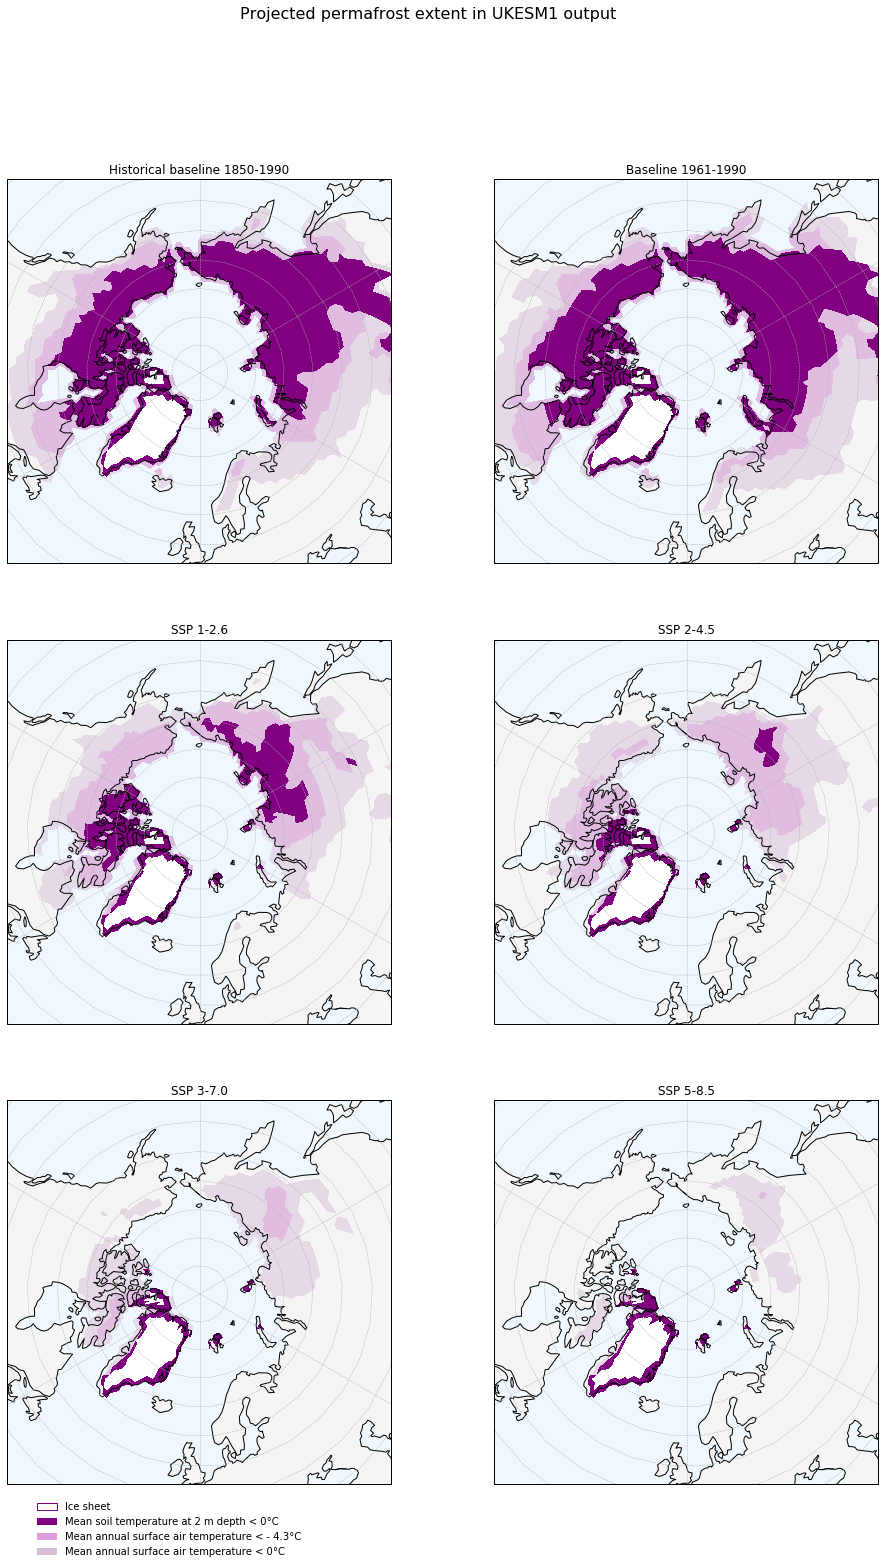

In [67]:
#ditch all of those bloody dask warnings
import warnings
warnings.simplefilter("ignore") 

#define cartopy projections
projection=ccrs.NorthPolarStereo()
transform = ccrs.PlateCarree()

#set up figure
#sublot_kw hack from cartopy/mpl formum
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,24),
                        subplot_kw=dict(projection=projection))
fig.suptitle('Projected permafrost extent in UKESM1 output',fontsize=16)
titles = ('Historical baseline 1850-1990','Baseline 1961-1990','SSP 1-2.6','SSP 2-4.5',
          'SSP 3-7.0','SSP 5-8.5')
masks = (maskhist,maskbl,mask126,mask245,mask370,mask585)
startyear = (1850,1961,2090,2090,2090,2090)
endyear = (1900,1991,2099,2099,2099,2099)

#plot on subplot
for ax,m,t in zip(axes.flat,masks,titles):
    ax.set_title(t)
    ax.set_extent([-180,180,50,90],ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5,linestyle='--')
    ax.coastlines()
    ax.add_feature(cartopy.feature.OCEAN,facecolor='aliceblue')
    ax.add_feature(cartopy.feature.LAND, facecolor='whitesmoke')
    im = ax.contourf(lon,lat,m[1],transform=transform,colors='thistle',alpha=0.5)
    im = ax.contourf(lon,lat,m[2],transform=transform,colors='plum',alpha=0.5)
    im = ax.contourf(lon,lat,m[0],transform=transform,colors='purple')
    im = ax.contourf(lon,lat,m[3],transform=transform, colors='white')
    im = ax.contourf(lon,lat,m[4],transform=transform, colors='aliceblue')

ice = patches.Rectangle((0, 0), 1, 1, facecolor="white",edgecolor='purple')
pfarea = patches.Rectangle((0, 0), 1, 1, facecolor="purple")
satarea1 = patches.Rectangle((0, 0), 1, 1, facecolor="plum")
satarea2 = patches.Rectangle((0, 0), 1, 1, facecolor="thistle")
labels = ['Ice sheet',
          'Mean soil temperature at 2 m depth < 0\u00B0C',
          'Mean annual surface air temperature < - 4.3\u00B0C',
          'Mean annual surface air temperature < 0\u00B0C']
plt.legend([ice, pfarea, satarea1,satarea2], labels,loc='lower center', 
           bbox_to_anchor=(-1.2, -0.2, 1., .2),mode="expand", borderaxespad=0.,frameon=False)

#### Permafrost area calculations and comparison with observational datasets

In [60]:
#calculate permafrost area for comparison with other datasets

def get_areas(soil,air,snow,startyear,endyear):
    '''function to derive masks for plotting maps for variable and scenario
    Arguments:
    =========
    soil = array of str, ccontaining variable[0], letter[1], senario[2]
    air
    snow
    startyear, endyear'''
    
    #get the mean for soil
    d = soil.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    d1 = d['tsl']
    d2 = d1.sel(depth=2.0,method='nearest')
    d3 = d2-273.15
    d4 = d3.mean(dim='time')
    
    #mask sum for pf areas
    smask = d4
    smask = xr.where(smask>=0,np.nan,smask)
    smask = xr.where(smask<0,1,smask)
    soilarea = np.multiply(smask,lndarea)
    soilsum = np.nansum(soilarea)
    
    #get annual mean air
    a = air.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    a1 = a['tas']
    a2 = a1-273.15
    a3 = a2.mean(dim='time')
    
    #mask for airtemp contours
    a0mask = a3
    a0mask = xr.where(a0mask>=0,np.nan,a0mask)
    a0mask = xr.where(a0mask<0,1,a0mask)
    a0area = np.multiply(a0mask,lndarea)
    a0sum = np.nansum(a0area)
    
    a43mask = a3
    a43mask = xr.where(a43mask>=-4.3,np.nan,a43mask)
    a43mask = xr.where(a43mask<-4.3,1,a43mask)
    a43area = np.multiply(a43mask,lndarea)
    a43sum = np.nansum(a43area)
    
    #get 10-yr mean snow coverage
    sn = snow.sel(time=slice(f'{startyear}-01-01',f'{endyear}-12-16'))
    sn1 = sn['snc']
    sn2 = sn1.mean(dim='time')

    #snow mask
    sncmask = sn2
    sncmask = xr.where(sncmask<95,np.nan,sncmask)
    sncmask = xr.where(sncmask>=95,1,sncmask)
    snarea = np.multiply(sncmask,lndarea)
    snsum = np.nansum(snarea)
    
    pfarea = soilsum - snsum
    a0area = a0sum - snsum
    a43area = a43sum - snsum
    
    return pfarea,a0area,a43area
    

28007398000000.0

Comparison of detected permafrost areas (2000-2009) with observational datasets (adapted from Burke et al., 2020)). 

|Dataset|Permafrost extent|Discontinuous permafrost (-4.3°C air contour)| Permafrost affected area (0°C air contour)|
|---|---|---|---|
|Brown et al. (1998)| 17.1 | 18.7 | 24.3 |
|Chadburn et al. (2017)| 15.3 | 15.1 | 24.7 |
|Obu et.al (2019)| 13.6 | 13.5 | 20.0 |
|Current method| 15.1 | 18.4 | 28.0 |

#### Plotting a time series of permafrost area

In [64]:
#generate series of pf area (this needs work to get a better rolling mean)

def pf_series(soil,snow,startyear,endyear):
    #years = np.unique(soil['time.year'])  
    years = np.arange(startyear,endyear+1)
    pf_series = np.zeros(years.shape)
    sz = range(len(years))
    
    for x,s in zip(years,sz):
        #get 2-yr mean soil temp
        d = soil.sel(time=slice(f'{x}-01-01',f'{x+1}-12-16'))
        d1 = d['tsl']
        d2 = d1.sel(depth=2.0,method='nearest')
        d3 = d2-273.15
        d4 = d3.mean(dim='time')
                
        #get 2-yr mean snow coverage
        sn = snow.sel(time=slice(f'{x}-01-01',f'{x+1}-12-16'))
        sn1 = sn['snc']
        sn2 = sn1.mean(dim='time')
        
        #snow mask and calculate area
        sncmask = sn2
        sncmask = xr.where(sncmask<95,np.nan,sncmask)
        sncmask = xr.where(sncmask>=95,1,sncmask)
        snarea = np.multiply(sncmask,lndarea)
        snsum = np.nansum(snarea)
        
        mask = d4
        mask = xr.where(mask>=0,np.nan,mask)
        mask = xr.where(mask<0,1,mask)
        d5 = np.multiply(mask,lndarea)
        d6 = np.nansum(d5)
        
        pfarea = d6-snsum
        pf_series[s]=pfarea/1000000
    
    return pf_series 

pf_hist = pf_series(tsl126,snc126,1850,2014)
pf_126 = pf_series(tsl126,snc126,2014,2100)
pf_245 = pf_series(tsl245,snc245,2014,2100)
pf_370 = pf_series(tsl370,snc370,2014,2100)
pf_585 = pf_series(tsl585,snc585,2014,2100)

Text(0.5, 1.0, 'Permafrost area over time')

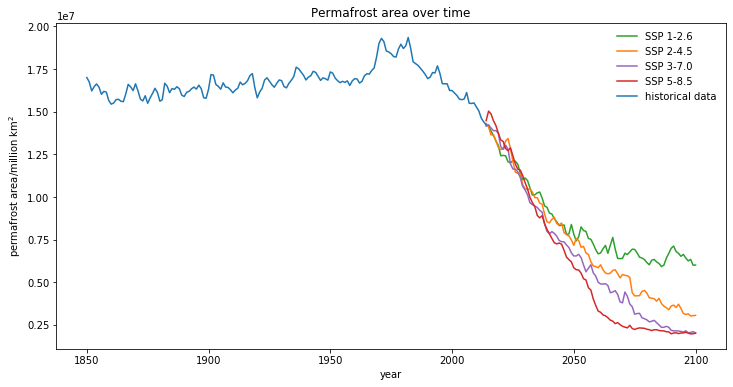

In [66]:
#plot permafrost area over time
x = range(2014,2101)
y = range(1850,2015)
fig = plt.figure(figsize=(12,6))

plt.plot(x,pf_126,color='#2CA02C',label='SSP 1-2.6')
plt.plot(x,pf_245,color='#FF7F0E',label='SSP 2-4.5')
plt.plot(x,pf_370,color='#9467BD',label='SSP 3-7.0')
plt.plot(x,pf_585,color='#D62728',label='SSP 5-8.5')
plt.plot(y,pf_hist,label='historical data')
plt.legend(loc='best',frameon=False)
plt.xlabel('year')
plt.ylabel('permafrost area/million km$^2$')
plt.title('Permafrost area over time')

#### Creating an animated gif of the permafrost maps

In [ ]:
#create map image for each year

startyear = 1850
endyear = 2099
years = range(startyear,endyear+1)
nyrs = range(1,len(years)+1)
len(nyrs)

#define cartopy projections
projection=ccrs.NorthPolarStereo()
transform = ccrs.PlateCarree()

#loop through each year
for y,i in zip(years,nyrs):
    tsl,sat0,sat43,sn,ocean = get_pf(tsl585,sat585,snc585,y)
    plt.ioff()
    
    #text for title
    text = AnchoredText(f'{y}',
                        loc=2,pad=1,frameon=False,
                        prop={'backgroundcolor': 'none','size': 16})
    
    #set up figure
    fig = plt.figure(figsize=(8,8))
    
    ax = plt.axes(projection=projection)
    ax.set_extent([-180,180,45,90],ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5,linestyle='--')
    ax.coastlines()
    ax.add_feature(cartopy.feature.OCEAN,facecolor='aliceblue')
    ax.add_feature(cartopy.feature.LAND, facecolor='whitesmoke')
    ax.add_artist(text)
    ax.contourf(lon,lat,sat0,transform=transform,colors='thistle',alpha=0.5)
    ax.contourf(lon,lat,sat43,transform=transform,colors='plum',alpha=0.5)
    ax.contourf(lon,lat,tsl,transform=transform,colors='purple')
    ax.contourf(lon,lat,sn,transform=transform,colors='white')
    ax.contourf(lon,lat,ocean,transform=transform, colors='aliceblue')
    
    #legend
    ice = patches.Rectangle((0, 0), 1, 1, facecolor="white",edgecolor='purple')
    pfarea = patches.Rectangle((0, 0), 1, 1, facecolor="purple")
    satarea1 = patches.Rectangle((0, 0), 1, 1, facecolor="plum")
    satarea2 = patches.Rectangle((0, 0), 1, 1, facecolor="thistle")
    labels = ['Ice sheet',
              'Continuous permafrost (>90%)',
              'Discontinuous permafrost (>50%)',
              'Permafrost affected area (>1%)']
    plt.legend([ice,pfarea, satarea1,satarea2], labels,loc='lower left',frameon=True,
               fontsize=12,framealpha=1,facecolor='white',edgecolor='grey')
    plt.savefig(f'../03-output-graphics/gifs/ssp585/ssp585_{i:04d}.png',dpi=80,bbox_inches='tight')
    plt.close(fig)
    ax.clear()

In [ ]:
#create gif direct in the command line using ImageMagick
magick convert -delay 12 frames/frame_*.png -delay 200 frames/fina/frame_0250.png 
-dispose background -loop 0 testdelay.gif

![SegmentLocal](../03-output-graphics/gifs/ssp370/ssp370.gif "SSP 3-7.0")

### References

Brown, J.: Circumpolar Active-Layer Monitoring (CALM) Program: Description and data., Circumpolar active-layer permafrost system, version 2.0., edited by: Parsons, M. and Zhang, T., International Permafrost Association Standing Committee on Data Information and Communication, available at: https://www2.gwu.edu/~calm/data/north.htm 

Chadburn, S. E. et al. (2017) An observation-based constraint on permafrost loss as a function of global warming. Nature Climate Change. [Online] 7 (5), 340–344.

Eyring, V. et al. (2016) Overview of the Coupled Model Intercomparison Project Phase 6 (CMIP6) experimental design and organization. Geoscientific Model Development. [Online] 9 (5), 1937–1958.

Obu, J. et al. (2019) Northern Hemisphere permafrost map based on TTOP modelling for 2000–2016 at 1 km2 scale. Earth-Science Reviews. [Online] 193299–316.

O’Neill, B. C. et al. (2016) The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geoscientific Model Development. [Online] 9 (9), 3461–3482.

Slater, A. G. & Lawrence, D. M. (2013) Diagnosing Present and Future Permafrost from Climate Models. Journal of Climate. [Online] 26 (15), 5608–5623.